<h1>Chapter 9: Unsupervised Learning Techniques</h1>

Although most of the applications of ML today are based on supervised learning, the vast majority of the available data is unlabeled: we have the input features X but don't have the labels y. 

<h2>9.1 Clustering Algorithms: k-means and DBSCAN</h2>

<em>Clustering</em> is the task of identifying similar instances and assigning them to clusters, or groups of similar instances. Just like in classification , each instance gets assigned to a group. However, unlike classification, clustering is an unsupervised learning task. 

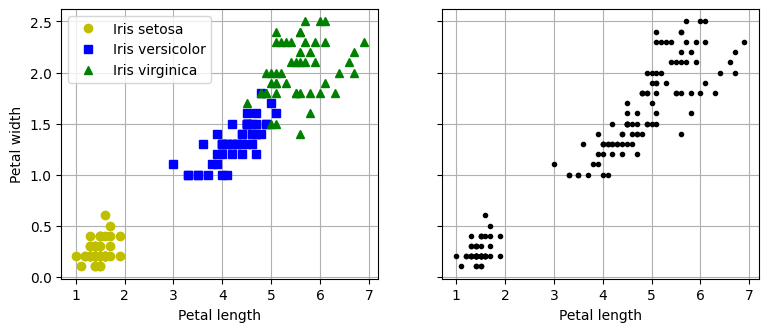

In [2]:
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris

data = load_iris()
X = data.data
y = data.target
data.target_names

plt.figure(figsize=(9, 3.5))

plt.subplot(121)
plt.plot(X[y==0, 2], X[y==0, 3], "yo", label="Iris setosa")
plt.plot(X[y==1, 2], X[y==1, 3], "bs", label="Iris versicolor")
plt.plot(X[y==2, 2], X[y==2, 3], "g^", label="Iris virginica")
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.grid()
plt.legend()

plt.subplot(122)
plt.scatter(X[:, 2], X[:, 3], c="k", marker=".")
plt.xlabel("Petal length")
plt.tick_params(labelleft=False)
plt.gca().set_axisbelow(True)
plt.grid()

plt.show()

In the above figure, on the left is the iris dataset, where each instance's species is represented with a different marker. It is a labeled dataset, for which classification algorithms such as logistic regression, SVMs, or random forest classifiers are well suited.

On the right is the same dataset, but without labels, so you can't use a simple classification algorithm anymore. This is where clustering algorithms step in: many of them can easily detect the lower-left cluster. 

<h3>9.1.1 k-means</h3>

Consider the unlabeled dataset represented below.

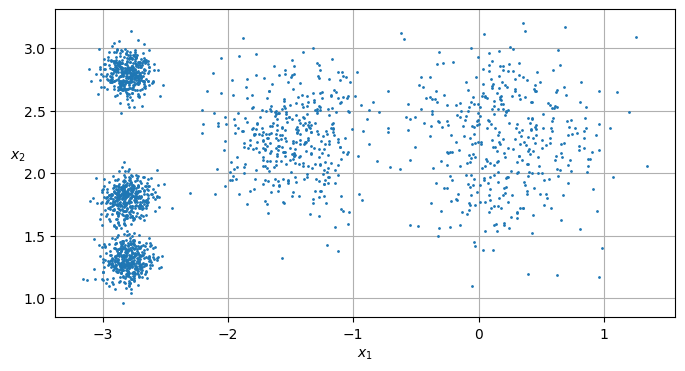

In [9]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
import numpy as np

# extra code – the exact arguments of make_blobs() are not important
blob_centers = np.array([[ 0.2,  2.3], [-1.5 ,  2.3], [-2.8,  1.8],
                         [-2.8,  2.8], [-2.8,  1.3]])
blob_std = np.array([0.4, 0.3, 0.1, 0.1, 0.1])
X, y = make_blobs(n_samples=2000, centers=blob_centers, cluster_std=blob_std, random_state=7)

def plot_clusters(X, y=None):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=1)
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$", rotation=0)

plt.figure(figsize=(8, 4))
plot_clusters(X)
plt.gca().set_axisbelow(True)
plt.grid()
plt.show()

In this dataset, you can clearly see five blobs of instances. The k-means algorithm is a simple algorithm capable of clustering this kind of dataset very quickly and efficiently, often in just a few iterations. 

Let's train a k-means clusterer on this dataset. It will try find each blob's center and assign each instance to the closest blob:

In [10]:
k = 5
kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
y_pred = kmeans.fit_predict(X)

Each instance was assign to one of the 5 clusters:

In [11]:
y_pred

array([0, 0, 4, ..., 3, 1, 0], dtype=int32)

And the following 5 centroids were estimated:

In [12]:
kmeans.cluster_centers_

array([[-2.80214068,  1.55162671],
       [ 0.08703534,  2.58438091],
       [-1.46869323,  2.28214236],
       [-2.79290307,  2.79641063],
       [ 0.31332823,  1.96822352]])

You can easily assign new instances to the cluster whose centroid is closest:

In [13]:
import numpy as np

X_new = np.array([[0, 2], [3, 2], [-3, 3], [-3, 2.5]])
kmeans.predict(X_new)

array([4, 4, 3, 3], dtype=int32)

If you plot the cluster's decision boundaries, you get a Voroni tesselation. In the below figure, each centroid is represented with an X:

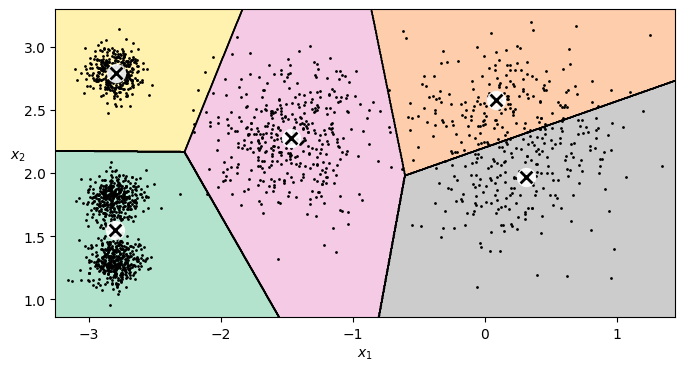

In [15]:
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=35, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=2, linewidths=12,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$")
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", rotation=0)
    else:
        plt.tick_params(labelleft=False)

plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans, X)
plt.show()

Instead of assigning each instance to a single cluster, which is called <em>hard clustering</em>, it can be useful to give each instance a score per cluster, which is called <em>soft clustering</em>. The score cab be the distance between the instance and the centroid or a similar score (or affinity).

In the KMeans class, the transform() method measures the distance from each instance to every centroid:

In [16]:
kmeans.transform(X_new).round(2)

array([[2.84, 0.59, 1.5 , 2.9 , 0.31],
       [5.82, 2.97, 4.48, 5.85, 2.69],
       [1.46, 3.11, 1.69, 0.29, 3.47],
       [0.97, 3.09, 1.55, 0.36, 3.36]])